In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# pip install networkx numpy pandas matplotlib

# Basics of Reinforcement Learning

## Markov Decision Process: Policy Iteration

The system is not yet learning a meaningful policy.

I am still:

* trying to understand whether the policy iteration is doing what it's supposed to be doing
 * basically; are there bugs in the code (suspecting signs errors at this point...)
* trying to understand the dynamics of the system I created
 * should be symmetric\non-symmetric in terms of winning\losing?
 * should the probabilities be 50%/50% and the rewards make the distinctions?
 * does the nature of the problem make it that there is some kind of clear "linear" behavior in the system?

Notes:

* The system seems to be split into two highly polarized strategies: either "all wrong" strategies or "all right" strategies - the variation within those strategies is negligible to the human eye.
 * Separating the true differences might require a huge N.
* What the policy iteration learns is not clear to me -- as to whether it learns a "winning" or "losing" strategy, but the probabilities within the graph *do* have a clear impact on what policy the policy iteration finds optimal.

In [38]:
class MDP:
    def __init__(self, gamma=0.98, max_calls=1_000_000):

        self.gamma = gamma
        self.max_calls = max_calls
        self.calls = 0
        
        self.actions = ['Bet HEADS', 'Bet TAILS']  # "reflip + bet on 0" and "reflip + bet on 1"
        self.states = [0, 1, 2, 3, 4]

        self.N_STATES = len(self.states)
        self.N_ACTIONS = len(self.actions)

        self.P = np.zeros((self.N_STATES, self.N_ACTIONS, self.N_STATES))
        self.R = np.zeros((self.N_STATES, self.N_ACTIONS, self.N_STATES))

        
        START_STATE, BLUE_STATE, RED_STATE, YELLOW_STATE, FINAL_STATE = 0, 1, 2, 3, 4

        ########  the state transition probabilities + rewards for taking actions
        
        
        # if you want to make the transitions not symmetric for heads + tails, you have to add 0 and 1 here separately
        self.P[RED_STATE, :, START_STATE] = 0.5
        self.P[FINAL_STATE, :, START_STATE] = 0.5
        
        self.R[RED_STATE, 0, START_STATE] = +0.35
        self.R[RED_STATE, 1, START_STATE] = -0.35
        
        self.R[FINAL_STATE, 0, START_STATE] = -0.35
        self.R[FINAL_STATE, 1, START_STATE] = +0.35
        
        ########
        
        
        self.P[RED_STATE, :, BLUE_STATE] = 0.5
        self.P[START_STATE, :, BLUE_STATE] = 0.5
        
        self.R[RED_STATE, 0, BLUE_STATE] = +0.25
        self.R[RED_STATE, 1, BLUE_STATE] = -0.25
        
        self.R[START_STATE, 0, BLUE_STATE] = -0.25
        self.R[START_STATE, 1, BLUE_STATE] = +0.25
        
        ########
        
        self.P[YELLOW_STATE, :, RED_STATE] = 0.5
        self.P[START_STATE, :, RED_STATE] = 0.5
        
        self.R[YELLOW_STATE, 0, RED_STATE] = +0.22
        self.R[YELLOW_STATE, 1, RED_STATE] = -0.22
        
        self.R[START_STATE, 0, RED_STATE] = -0.31
        self.R[START_STATE, 1, RED_STATE] = +0.31  
        
        ########
        
        self.P[BLUE_STATE, :, YELLOW_STATE] = 0.5
        self.P[START_STATE, :, YELLOW_STATE] = 0.5
        
        self.R[BLUE_STATE, 0, YELLOW_STATE] = +0.3
        self.R[BLUE_STATE, 1, YELLOW_STATE] = -0.3
        
        self.R[START_STATE, 0, YELLOW_STATE] = -0.3
        self.R[START_STATE, 1, YELLOW_STATE] = +0.3
        
        ######
        
        self.P[YELLOW_STATE, :, FINAL_STATE] = 0.5
        self.P[BLUE_STATE, :, FINAL_STATE] = 0.5
        
        self.R[YELLOW_STATE, 0, FINAL_STATE] = +0.33
        self.R[YELLOW_STATE, 1, FINAL_STATE] = -0.33
        
        self.R[BLUE_STATE, 0, FINAL_STATE] = -0.31
        self.R[BLUE_STATE, 1, FINAL_STATE] = +0.31
        
        
        ZERO_TRANSITIONS = self.P[:, 0, :]
        ONE_TRANSITIONS = self.P[:, 1, :]
        
        ALL_TRANSITIONS = ZERO_TRANSITIONS + ONE_TRANSITIONS
        
        X = (ALL_TRANSITIONS==0)
        Y = (ALL_TRANSITIONS==1)
        
        assert (X|Y).all()
        #assert (self.R[:, 0, :] == -self.R[:, 1, :]).all()
    
        ###########
    
    
        self.V = np.zeros(self.N_STATES)
        self.state = 0
        self.reward = 0

    def __call__(self, policy):

        self.calls += 1
        if self.calls > self.max_calls:
            return self.V, self.policy, False, 0.0
        
        
        if self.calls % 100000 == 0:
            print(f"{self.calls}")
            
        epsilons = list()

        g = self.gamma
        is_value_changed = False

        for s in range(self.N_STATES):
            self.V[s] = sum([self.P[s1, policy[s], s] * (self.R[s1, policy[s], s] + g * self.V[s1]) for s1 in range(self.N_STATES)])

        for s in range(self.N_STATES):
            q_best = self.V[s]

            for a in range(self.N_ACTIONS):
                # try all actions but the probabilities of SOME of them happening should be zero

                q_sa = [self.P[s1, a, s] * (self.R[s1, a, s] + g * self.V[s1]) for s1 in range(self.N_STATES)]
                # print(policy, s, a, q_sa, sum(q_sa), q_best)
                q_sa = sum(q_sa)

                if q_sa > q_best:  # does it matter if q_best is negative? and if q_sa is also negative?
                    epsilon = abs(q_sa - q_best)

                    epsilons.append(epsilon)
                    #print(f"found best new policy at {s} [{a}]! {q_best} < {q_sa}")
                    policy[s] = a

                    q_best = q_sa
                    is_value_changed = True

        self.policy = policy

        return self.V, policy, is_value_changed, max(epsilons)

    def play(self, policy):

        state = self.state
        action = policy[state]

        P = self.P[:, action, state]

        P_probab = P[P > 0]
        P_states = P_probab.nonzero()[0]

        try:
            next_state = np.random.choice(P_states, size=1, p=P_probab)[0]
            reward = self.R[next_state, action, state]

            self.reward += reward
            self.state = next_state
        except ValueError as v:
            print("valueerror", v, P_probab)
            
            
REWARDS = MDP().R[:,0,:]
PROBABILITIES = MDP().P[:, 0, :]

POS, NEG = [(b,a) for (a,b) in zip(*np.where(REWARDS > 0))], [(y,x) for x,y in zip(*np.where(REWARDS < 0))]

EDGELABELS = {**{edge: f"{100*prob}%" for edge, prob in zip(POS, PROBABILITIES[REWARDS > 0])}, **{edge:f"{100*prob}%" for edge, prob in zip(NEG, PROBABILITIES[REWARDS < 0])}}



optimal = MDP(gamma=0.9999, max_calls=300_000)

policy = [0, 1, 1, 1, 0]

epsilon = 1

while epsilon > 1e-6:
    
    old_policy = f"{policy}"
    
    value, policy, changed, epsilon = optimal(policy)

    if old_policy != f"{policy}":
        print(f"New policy {policy}")
    
    #print(value, changed, policy, epsilon)
    #print("-" * 80)

print("DONE")

New policy [0, 0, 1, 1, 0]
New policy [0, 1, 1, 0, 0]
New policy [0, 0, 1, 0, 0]
New policy [0, 1, 1, 0, 0]
New policy [0, 0, 1, 0, 0]
New policy [0, 1, 1, 1, 0]
New policy [0, 0, 1, 1, 0]
New policy [0, 0, 1, 0, 0]
New policy [1, 0, 1, 0, 0]
New policy [0, 0, 1, 1, 0]
New policy [0, 0, 1, 0, 0]
New policy [0, 0, 1, 1, 0]
New policy [0, 0, 1, 0, 0]
New policy [0, 0, 1, 1, 0]
New policy [1, 0, 1, 0, 0]
New policy [0, 1, 1, 0, 0]
New policy [0, 0, 1, 0, 0]
New policy [0, 0, 1, 1, 0]
New policy [0, 0, 1, 0, 0]
New policy [0, 0, 1, 1, 0]
New policy [1, 0, 1, 1, 0]
New policy [1, 0, 1, 0, 0]
New policy [0, 0, 1, 0, 0]
New policy [1, 0, 1, 0, 0]
New policy [0, 0, 1, 0, 0]
New policy [1, 0, 1, 0, 0]
New policy [0, 0, 1, 0, 0]
New policy [1, 0, 1, 0, 0]
New policy [0, 0, 1, 0, 0]
New policy [1, 0, 1, 0, 0]
New policy [0, 0, 1, 0, 0]
New policy [1, 0, 1, 0, 0]
New policy [0, 0, 1, 0, 0]
New policy [1, 0, 1, 0, 0]
New policy [0, 0, 1, 0, 0]
New policy [1, 0, 1, 0, 0]
New policy [0, 0, 1, 0, 0]
N

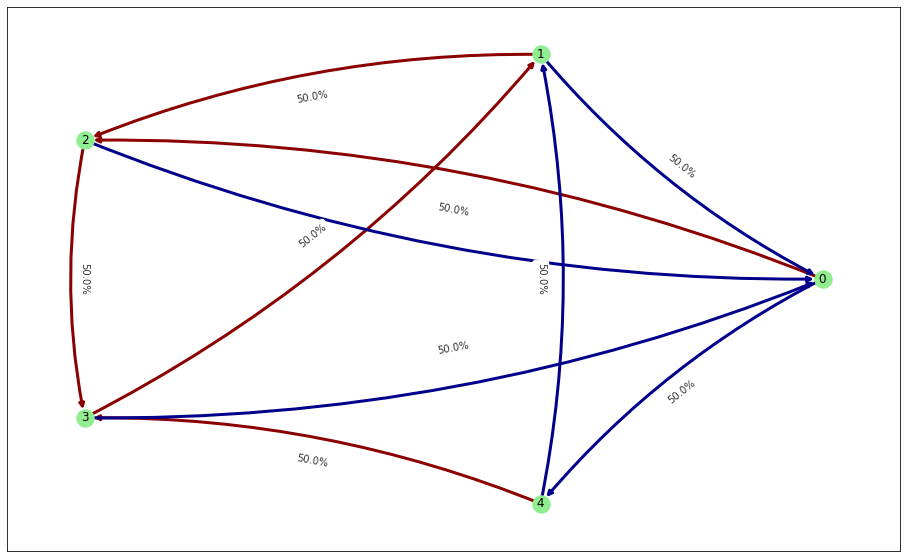

In [39]:
GAME = nx.MultiDiGraph()


GAME_ADJ = nx.from_numpy_matrix(MDP().R[:, 0, :], parallel_edges=True, create_using=nx.MultiDiGraph)
GAME.add_edges_from(GAME_ADJ.edges(data=True))

GAME_pos = nx.circular_layout(GAME)

plt.figure(figsize=(16,10))

nx.draw_networkx_labels(GAME, pos=GAME_pos)
nx.draw_networkx_edges(GAME, pos=GAME_pos, edgelist=POS, connectionstyle=f'arc3, rad=0.1', width=3, edge_color='darkred')
nx.draw_networkx_edges(GAME, pos=GAME_pos, edgelist=NEG, connectionstyle=f'arc3, rad=0.1', width=3, edge_color='darkblue')


nx.draw_networkx_edge_labels(GAME, pos=GAME_pos, edge_labels=EDGELABELS, alpha=0.8)

nx.draw_networkx_nodes(GAME, pos=GAME_pos, node_color='lightgreen')

(0, 0, 0, 0, 0)	0	5000	10000	15000	20000	
(0, 0, 0, 0, 1)	0	5000	10000	15000	20000	
(0, 0, 0, 1, 0)	0	5000	10000	15000	20000	
(0, 0, 0, 1, 1)	0	5000	10000	15000	20000	
(0, 0, 1, 0, 0)	0	5000	10000	15000	20000	
(0, 0, 1, 0, 1)	0	5000	10000	15000	20000	
(0, 0, 1, 1, 0)	0	5000	10000	15000	20000	
(0, 0, 1, 1, 1)	0	5000	10000	15000	20000	
(0, 1, 0, 0, 0)	0	5000	10000	15000	20000	
(0, 1, 0, 0, 1)	0	5000	10000	15000	20000	
(0, 1, 0, 1, 0)	0	5000	10000	15000	20000	
(0, 1, 0, 1, 1)	0	5000	10000	15000	20000	
(0, 1, 1, 0, 0)	0	5000	10000	15000	20000	
(0, 1, 1, 0, 1)	0	5000	10000	15000	20000	
(0, 1, 1, 1, 0)	0	5000	10000	15000	20000	
(0, 1, 1, 1, 1)	0	5000	10000	15000	20000	
(1, 0, 0, 0, 0)	0	5000	10000	15000	20000	
(1, 0, 0, 0, 1)	0	5000	10000	15000	20000	
(1, 0, 0, 1, 0)	0	5000	10000	15000	20000	
(1, 0, 0, 1, 1)	0	5000	10000	15000	20000	
(1, 0, 1, 0, 0)	0	5000	10000	15000	20000	
(1, 0, 1, 0, 1)	0	5000	10000	15000	20000	
(1, 0, 1, 1, 0)	0	5000	10000	15000	20000	
(1, 0, 1, 1, 1)	0	5000	10000	15000

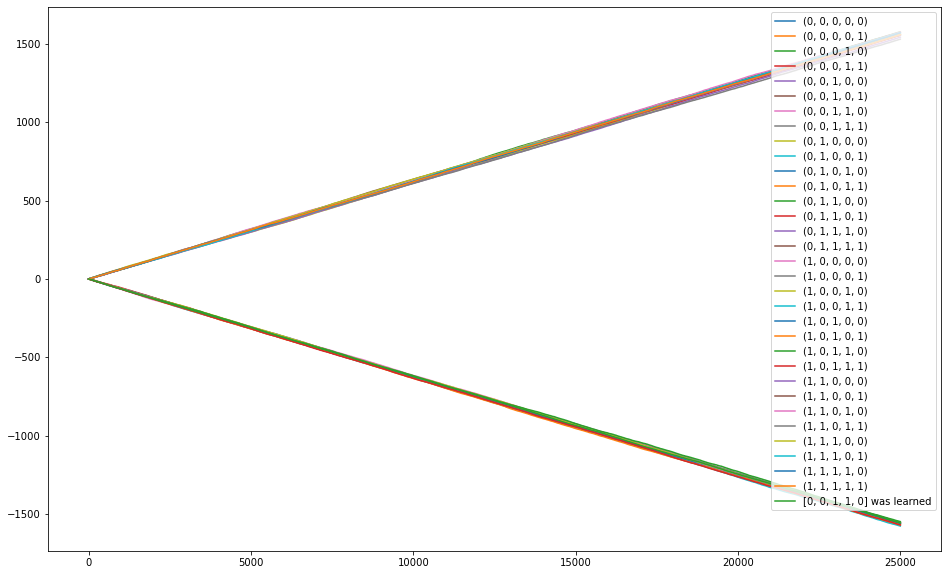

In [40]:
rewards = {}

ITERATIONS = 25_000



###### NOTE:
#######################

# 
# AT THIS POINT OUR SYSTEM ONLY *HAS*  2**5 policies so creating new policies at random doesn't make sense
#  -- we could just bruteforce the whole problem and not use RL at all.

# we will need a larger problem to truly see the benefits of RL but here we can test whether we attain the same solution
# as bruteforce (!)
import itertools


ALL_POLICIES = list(itertools.product([0, 1], repeat=5))
ZERO_STARTED = [(a, *b)  for a, b in zip([0]*16, list(itertools.product([0, 1], repeat=4)))]

######################
for trial in ALL_POLICIES:
    
    print(trial, end='\t')
    
    game = MDP()
    #policy = np.random.randint(0,2, size=5)
    policy = trial
    
    #print(trial, policy)
    
    latest_rewards = []

    for i in range(ITERATIONS):
    
        if i % 5_000 == 0:
            print(i, end='\t')
            
        game.play(policy=policy)

        latest_rewards.append(game.reward)

    print("")
    rewards[str(policy)] = latest_rewards


    
new_game = MDP()
learned_policy = optimal.policy
rewards[str(learned_policy) + " was learned"] = list()

for i in range(ITERATIONS):
    new_game.play(policy=learned_policy)
    rewards[str(learned_policy)  + " was learned"] .append(new_game.reward)



reward_df = pd.DataFrame(rewards)


print(reward_df.sort_values(by=ITERATIONS-1, axis=1, ascending=False).iloc[-1])

reward_df.plot(figsize=(16,10))

1773.1199999999214


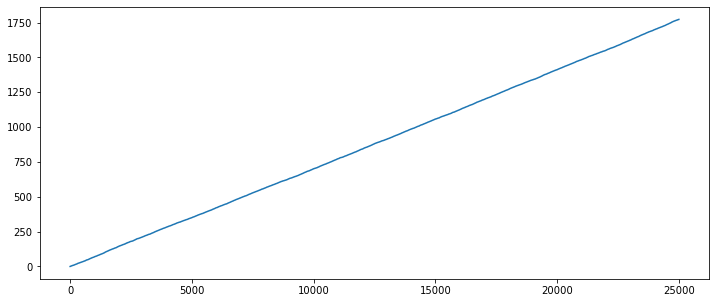

In [229]:
replay = MDP()

replay_exp = []

for i in range(ITERATIONS):
    replay.play(policy=[0, 1, 1, 0, 0])
    replay_exp.append(replay.reward)

    
print(replay_exp[-1])
pd.Series(replay_exp).plot(figsize=(12,5))

### Visualization including the Actions

* This has some benefits

In [259]:
P_zeros = optimal.P[:, 0, :]
P_ZERO_NODES = P_zeros.nonzero()

R_zeros = optimal.R[:, 0, :]
R_ZERO_REWARDS = R_zeros[P_ZERO_NODES]

P_ones = optimal.P[:, 1, :]
P_ONE_NODES = P_ones.nonzero()

R_zeros = optimal.R[:, 1, :]
R_ONE_REWARDS = R_zeros[P_ONE_NODES]

X_TO_STATES = [('Bet HEADS', to, {'reward': reward}) for to, reward in zip(P_ZERO_NODES[0], R_ZERO_REWARDS)]
Y_TO_STATES = [('Bet TAILS', to, {'reward': reward}) for to, reward in zip(P_ONE_NODES[0], R_ZERO_REWARDS)]

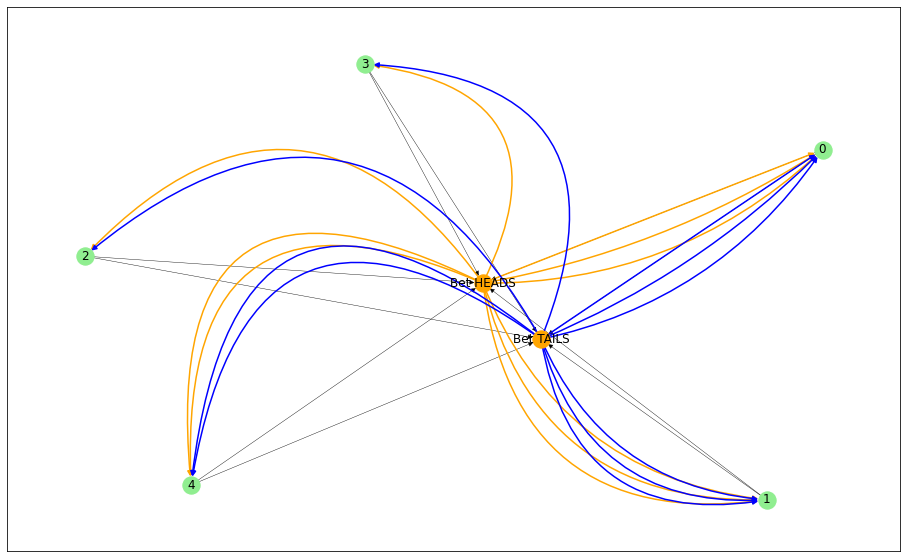

In [260]:
STATES = optimal.states 
ACTIONS = optimal.actions

NODES = STATES + ACTIONS

STATE_TO_ACTIONS = [(s, a) for s in STATES for a in ACTIONS]


G = nx.MultiDiGraph()
G.add_nodes_from(NODES)
G.add_edges_from(STATE_TO_ACTIONS)
G.add_edges_from(X_TO_STATES)
G.add_edges_from(Y_TO_STATES)

pos = nx.spring_layout(G)

plt.figure(figsize=(16,10))



nx.draw_networkx_labels(G, pos=pos)
nx.draw_networkx_edges(G, pos=pos, edgelist=STATE_TO_ACTIONS, width=0.4)#, connectionstyle='arc3,rad=0.1')


for i, edge in enumerate(X_TO_STATES):
    plus = i/10
    nx.draw_networkx_edges(G, pos=pos, edgelist=[edge], connectionstyle=f'arc3,rad={0+plus}', edge_color='orange', width=1.5)

for i, edge in enumerate(Y_TO_STATES):
    plus = i/10
    nx.draw_networkx_edges(G, pos=pos, edgelist=[edge], connectionstyle=f'arc3,rad={0+plus}', edge_color='blue', width=1.5)

nx.draw_networkx_nodes(G, pos=pos, nodelist=STATES, node_color='lightgreen')
nx.draw_networkx_nodes(G, pos=pos, nodelist=ACTIONS, node_color='orange')